In [1]:
%cd ..
%pip install -e .

/home/sandor/dtu/2021-22-spring/advanced_machine_learning/p-reg
Obtaining file:///home/sandor/dtu/2021-22-spring/advanced_machine_learning/p-reg
  Preparing metadata (setup.py) ... done
  Attempting uninstall: src
    Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0
  Running setup.py develop for src
Note: you may need to restart the kernel to use updated packages.


In [2]:
import random

import numpy as np
import pandas as pd

from src.models.dense import NN0
from src.models.dense import NN1
from src.models.gcn import GCN0
from src.models.gcn import GCN1
from src.models.gcn import GCN_var_2layer

from src.models.gat import GAT

from src.models.train_model import train_with_loss
from src.models.train_model import random_splits

from src.models.reg import make_preg_ce_ce
from src.models.reg import make_preg_ce_ce_alt
from src.models.reg import make_lap_loss_ce

from src.models.reg import compute_a_hat

from src.models.evaluate_model import evaluate0
from src.models.evaluate_model import evaluate1

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from sklearn.manifold import TSNE

from src.models.evaluate_model import test
from tqdm import tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=T.NormalizeFeatures())
data = dataset[0].to(device)

A_hat = compute_a_hat(data)

data.reg_mask = torch.ones_like(data.train_mask, dtype=torch.bool)


In [4]:
print('-------------------------------------------------------------')
print(f'train size: {data.train_mask.sum()}')
print(f'val size: {data.val_mask.sum()}')
print(f'test size: {data.test_mask.sum()}')
print('-------------------------------------------------------------')

metrics = []
for seed in [0,1,2,3,4]:
    for hidden_channels in [1, 2, 4, 8, 16, 32, 64, 128]:
        for mu in [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]:
            torch.manual_seed(seed)
            random.seed(seed)

            loss_fn = make_preg_ce_ce_alt(mu, A_hat)
            
            model = GCN_var_2layer(hidden_channels)
            # model = GCN1(num_node_features=dataset.num_node_features, num_classes=dataset.num_classes)
            model = train_with_loss(model, data, loss_fn, num_epochs=200)

            acc = evaluate0(model, data)

            train_acc, val_acc, test_acc = evaluate1(model, data)
            metrics.append({'seed': seed, 'hidden_channels': hidden_channels, 'mu': mu, 'train_acc': np.round(train_acc,4), 'val_acc': np.round(val_acc,4), 'test_acc': np.round(test_acc,4)})
            print(metrics[-1])
            # print(f'mu: {mu}, train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}, test_acc: {test_acc:.4f}')
            # print('-------------------------------------------------------------')


-------------------------------------------------------------
train size: 140
val size: 500
test size: 1000
-------------------------------------------------------------
{'seed': 0, 'hidden_channels': 1, 'mu': 0, 'train_acc': 0.4429, 'val_acc': 0.342, 'test_acc': 0.335}
{'seed': 0, 'hidden_channels': 1, 'mu': 0.1, 'train_acc': 0.4429, 'val_acc': 0.344, 'test_acc': 0.343}
{'seed': 0, 'hidden_channels': 1, 'mu': 0.2, 'train_acc': 0.4571, 'val_acc': 0.346, 'test_acc': 0.339}
{'seed': 0, 'hidden_channels': 1, 'mu': 0.3, 'train_acc': 0.4857, 'val_acc': 0.352, 'test_acc': 0.341}
{'seed': 0, 'hidden_channels': 1, 'mu': 0.4, 'train_acc': 0.4929, 'val_acc': 0.352, 'test_acc': 0.346}
{'seed': 0, 'hidden_channels': 1, 'mu': 0.5, 'train_acc': 0.4714, 'val_acc': 0.342, 'test_acc': 0.346}
{'seed': 0, 'hidden_channels': 1, 'mu': 0.6, 'train_acc': 0.4571, 'val_acc': 0.322, 'test_acc': 0.333}
{'seed': 0, 'hidden_channels': 1, 'mu': 0.7, 'train_acc': 0.4286, 'val_acc': 0.294, 'test_acc': 0.323}
{'seed':

In [10]:
df = pd.DataFrame(metrics)
df.to_csv('reports/figures/hidden_channels_mu.csv')
# ridiculously slow implementation, but I don't want to figure this out now
arr = np.zeros((df['hidden_channels'].unique().shape[0], df['mu'].unique().shape[0]))
for ind_i, i in enumerate(df['hidden_channels'].unique()):
    for ind_j, j in enumerate(df['mu'].unique()):
        # print((df['hidden_channels'] == i) & (df['mu'] == j))
        # print(df[(df['hidden_channels'] == i) & (df['mu'] == j)]['test_acc'])
        arr[ind_i,ind_j] = df[(df['hidden_channels'] == i) & (df['mu'] == j)]['test_acc'].mean()
# plt.pcolormesh()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


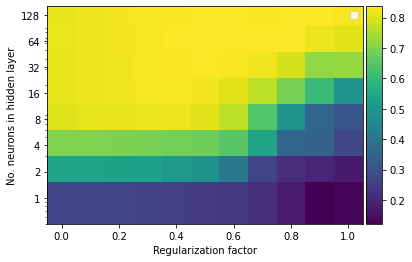

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

fig, ax = plt.subplots()
im = ax.pcolormesh([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.], [1, 2, 4, 8, 16, 32, 64, 128], arr, )
ax.set_yscale('log')
ax.set_yticks([1, 2, 4, 8, 16, 32, 64, 128])
ax.set_yticklabels([1, 2, 4, 8, 16, 32, 64, 128])
add_colorbar(im, fig, ax)
ax.set(xlabel='Regularization factor', ylabel='No. neurons in hidden layer')
ax.legend()
plt.show()


In [27]:
print(df[(df['mu']==0.4)&(df['hidden_channels']==32)]['test_acc'].mean())


0.8310000000000001


In [58]:
data.y.unique().numpy()

array([0, 1, 2, 3, 4, 5, 6])